# Fluctuation Analyses

This notebook covers 'fluctuation' analyses, which examine patterns of fluctuations in time series.

This notebook covers:
- The Hurst Exponent
- Detrended Fluctuation Analysis

In [1]:
from neurodsp.sim import sim_powerlaw, sim_synaptic_current, sim_knee, sim_combined
from neurodsp.aperiodic import compute_fluctuations
from neurodsp.utils import set_random_seed
from neurodsp.aperiodic.conversions import convert_exponent_alpha

In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.io import APMDB
from apm.run import run_sims, run_sims_load
from apm.methods import hurst, dfa
from apm.methods.settings import HURST_PARAMS, DFA_PARAMS
from apm.plts.sims import plot_sims, plot_ap_sims, plot_pe_sims, plot_sims_two
from apm.plts.settings import EXT, COLORS
from apm.sim.settings import N_SIMS
from apm.sim.examples import get_examples, check_examples
from apm.sim.defs import SIM_ITERS

In [3]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [4]:
# Set the random seed
set_random_seed(111)

In [5]:
# Settings for saving figures
SAVE_FIG = False
FIGPATH = APMDB().figs_path / '22_fluctuations'

In [6]:
# Settings for loading simulations
SIMPATH = APMDB().sims_path / 'time_series'

In [7]:
# Add data specific settings to method settings
HURST_PARAMS['fs'] = SIM_ITERS.fs
DFA_PARAMS['fs'] = SIM_ITERS.fs

In [8]:
# Define collection of example signals
examples = get_examples()

## Hurst Exponent

The Hurst exponent is a method for measuring the self-similarity of a signal.

In [9]:
# Check Hurst exponent settings
HURST_PARAMS

{'fs': 250, 'n_scales': 10, 'min_scale': 0.1, 'max_scale': 2.0}

### Hurst Exponent on Example Signals

Compute the Hurst exponent on some example signals.

In [10]:
# Define expected values for Hurst estimation
hurst_expected = {}
hurst_expected['powerlaw'] = 0.5

In [11]:
# Check the calculated hurst exponent, and the expected value
check_examples(examples, hurst, HURST_PARAMS, 'Hurst exponent', hurst_expected)

Computed Hurst exponent:
  powerlaw       : 	 0.5378 	0.50
  synaptic       : 	 0.5766
  knee           : 	 0.5475
  oscillation    : 	 -0.0033
  burst          : 	 nan
  combined       : 	 0.5027
  comb_burst     : 	 0.5049
  comb_peak      : 	 0.4780


/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/aperiodic/dfa.py:136: RuntimeWarning: divide by zero encountered in divide
  rs_win = np.ptp(segments, axis=0) / np.std(split_signal(sig, win_len).T, axis=0)


### Hurst Exponent: Aperiodic Variations

In [12]:
# Run simulations calculating Hurst across exponents
hurst_sims_exp = run_sims(sim_powerlaw, SIM_ITERS['ap_exp'], hurst, HURST_PARAMS, N_SIMS)

In [13]:
# Run simulations calculating Hurst across exponents, with an oscillation
hurst_sims_comb = run_sims(sim_combined, SIM_ITERS['comb_exp'], hurst, HURST_PARAMS, N_SIMS)

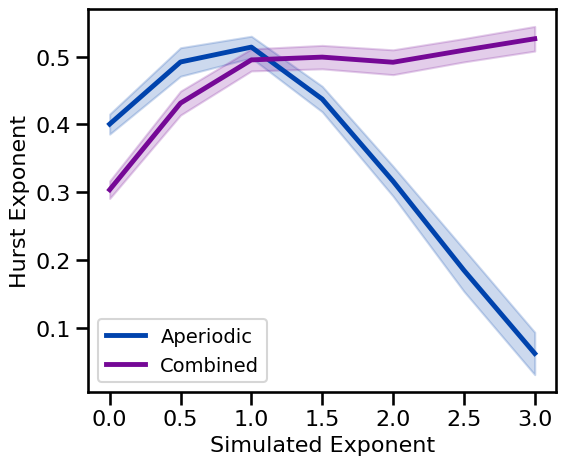

In [14]:
# Plot Hurst exponent estimates across aperiodic variations
plot_ap_sims(hurst_sims_exp, hurst_sims_comb, 'Hurst Exponent', 
             save_fig=SAVE_FIG, file_name='hurst_ap' + EXT, file_path=FIGPATH)

### Hurst Exponent: Periodic Variations

In [15]:
# Run simulations calculating Hurst Exponent across oscillation frequencies
hurst_sims_freq = run_sims(sim_combined, SIM_ITERS['osc_freq'], hurst, HURST_PARAMS, N_SIMS)

In [16]:
# Run simulations calculating Hurst Exponent across oscillation power
hurst_sims_pow = run_sims(sim_combined, SIM_ITERS['osc_pow'], hurst, HURST_PARAMS, N_SIMS)

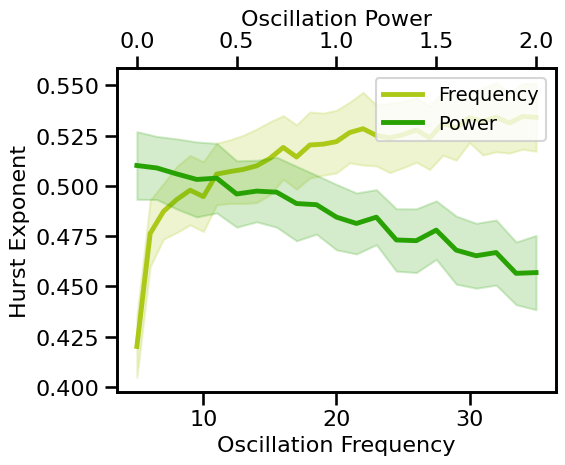

In [17]:
# Plot Hurst exponent estimates across periodic variations
plot_pe_sims(hurst_sims_freq, hurst_sims_pow, 'Hurst Exponent',
             save_fig=SAVE_FIG, file_name='hurst_pe' + EXT, file_path=FIGPATH)

### Hurst Exponent: Knee Variations

In [18]:
# Run simulations calculating Hurst Exponent across different timescales
hurst_sims_tscales = run_sims(sim_synaptic_current, SIM_ITERS['syn_tscales'], hurst, HURST_PARAMS, N_SIMS)

In [19]:
# Run simulations calculating Hurst Exponent across different knee parameters (sims from file)
hurst_sims_knee = run_sims_load(SIMPATH / 'ts_sims_ap_knee', hurst, HURST_PARAMS)

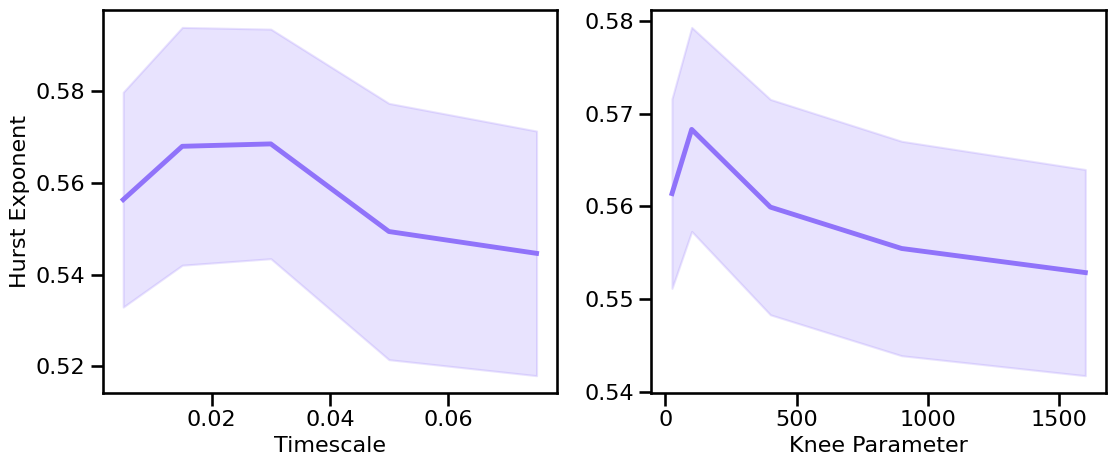

In [20]:
# Plot the estimated hurst exponent across different timescales & knees
plot_sims_two(SIM_ITERS['syn_tscales'].values, hurst_sims_tscales, 'Timescale',
              SIM_ITERS['kn_knee'].values, hurst_sims_knee, 'Knee Parameter',
              ylabel='Hurst Exponent', color=COLORS['KN'], 
              save_fig=SAVE_FIG, file_name='hurst_kn_vars' + EXT, file_path=FIGPATH)

### Hurst Exponent: Periodic Variations

Variations: oscillations bandwidth & burst probability.

In [21]:
# Run simulations calculating Hurst Exponent across peak bandwidth (sims from file)
hurst_sims_bw = run_sims_load(SIMPATH / 'ts_sims_comb_bw', hurst, HURST_PARAMS)

In [22]:
# Run simulations calculating Hurst Exponent across burst probabilities
hurst_sims_burst = run_sims(sim_combined, SIM_ITERS['comb_burst'], hurst, HURST_PARAMS, N_SIMS)

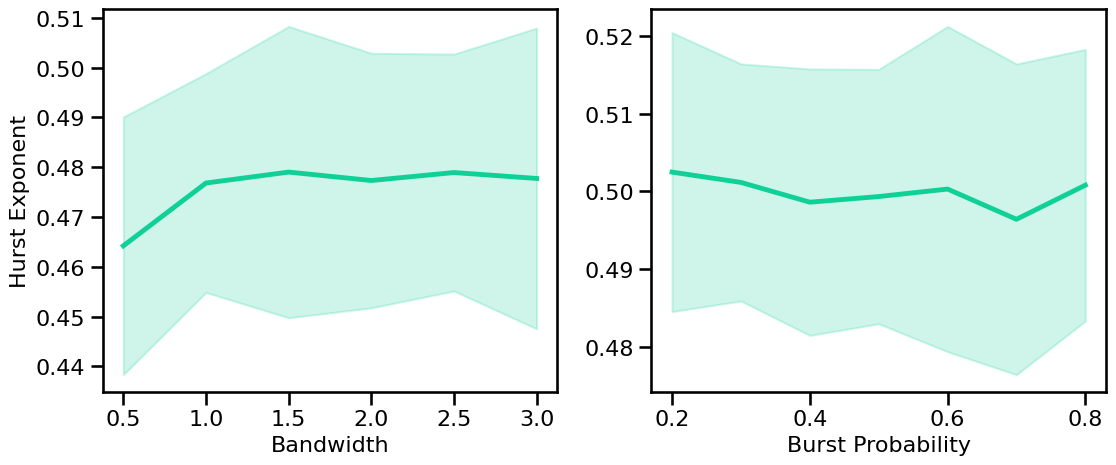

In [23]:
# Plot the estimated hurst exponent across periodic variations
plot_sims_two(SIM_ITERS['peak_bw'].values, hurst_sims_bw, 'Bandwidth',
              SIM_ITERS['comb_burst'].values, hurst_sims_burst, 'Burst Probability',
              ylabel='Hurst Exponent', color=COLORS['BW'],
              save_fig=SAVE_FIG, file_name='hurst_pe_vars' + EXT, file_path=FIGPATH)

## Detrended Fluctuation Analysis

Detrended Fluctuation Analysis is a method for measuring the self-similarity of a signal, and can be applied to measure properties of 1/f-distributed signals.

DFA measures an output value, $\alpha$ which can be interpreted as:
- $\alpha$ < 0.5   anti-correlated signal
- $\alpha$ ~= 0.5: uncorrelated / white noise
- $\alpha$ > 0.5: correlated
    - For example: pink noise ($1/f^1$) ~= 1 & brown noise ($1/f^2$) ~= 1.5

The DFA measure $\alpha$, _should_ relate to the power spectrum exponent $f^\chi$ as:
- $\chi$ = 2$\alpha$ - 1 or
- $\alpha$ = ($\chi$ + 1) / 2

### Settings

In [24]:
# Check DFA settings
DFA_PARAMS

{'fs': 250, 'n_scales': 10, 'min_scale': 0.1, 'max_scale': 2.0, 'deg': 1}

### DFA on Example Signals

In [25]:
# Define expected values for DFA exponent estimation
dfa_expected = {}
dfa_expected['powerlaw'] = convert_exponent_alpha(SIM_ITERS.params['ap']['exponent'])

In [26]:
# Check the computed DFA exponents on some example signals
check_examples(examples, dfa, DFA_PARAMS, 'DFA exponent', dfa_expected)

Computed DFA exponent:
  powerlaw       : 	 0.8164 	1.00
  synaptic       : 	 0.6384
  knee           : 	 0.6589
  oscillation    : 	 0.0078
  burst          : 	 0.0953
  combined       : 	 0.6173
  comb_burst     : 	 0.7456
  comb_peak      : 	 0.6221


### DFA Simulations: Aperiodic Variations

In [27]:
# Calculate the expected DFA exponent value for each powerlaw exponent
expected_dfa = [convert_exponent_alpha(exp) for exp in SIM_ITERS._iters['ap_exp']['values']]

In [28]:
# Run simulations calculating DFA across exponents
dfa_sims_exp = run_sims(sim_powerlaw, SIM_ITERS['ap_exp'], dfa, DFA_PARAMS, N_SIMS)

In [29]:
# Run simulations calculating DFA across exponents, with an oscillation
dfa_sims_comb = run_sims(sim_combined, SIM_ITERS['comb_exp'], dfa, DFA_PARAMS, N_SIMS)

#### Plot Aperiodic & Combined Together

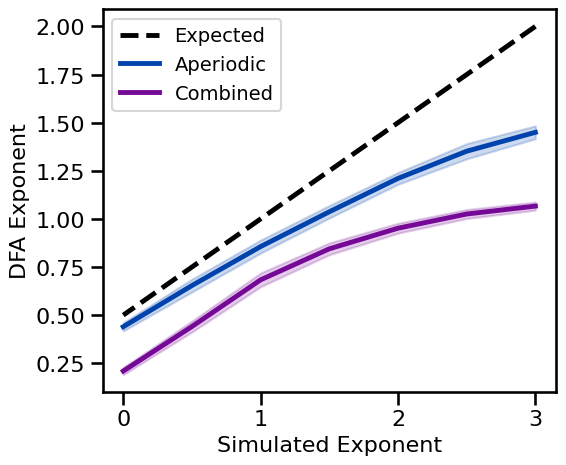

In [30]:
# Plot DFA measures across exponents
plot_ap_sims(dfa_sims_exp, dfa_sims_comb, 'DFA Exponent', expected=expected_dfa,
             save_fig=SAVE_FIG, file_name='dfa_ap' + EXT, file_path=FIGPATH)

### DFA Simulations: Periodic Variations

In [31]:
# Run simulations calculating DFA across oscillation frequencies
dfa_sims_freq = run_sims(sim_combined, SIM_ITERS['osc_freq'], dfa, DFA_PARAMS, N_SIMS)

In [32]:
# Run simulations calculating DFA across oscillation power
dfa_sims_pow = run_sims(sim_combined, SIM_ITERS['osc_pow'], dfa, DFA_PARAMS, N_SIMS)

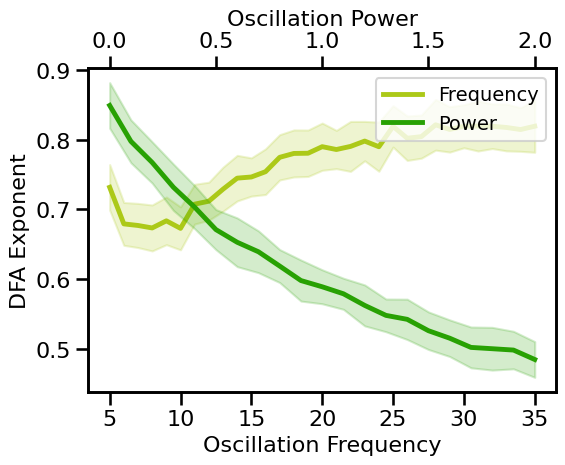

In [33]:
# Plot effect of oscillation variation on DFA exponent
plot_pe_sims(dfa_sims_freq, dfa_sims_pow, 'DFA Exponent', 
             save_fig=SAVE_FIG, file_name='dfa_pe' + EXT, file_path=FIGPATH)

### DFA Simulations: Knee Variations

In [34]:
# Run simulations calculating DFA Exponent across different timescales
dfa_sims_tscales = run_sims(sim_synaptic_current, SIM_ITERS['syn_tscales'], dfa, DFA_PARAMS, N_SIMS)

In [35]:
# Run simulations calculating DFA Exponent across different knee parameters (sims from file)
dfa_sims_knee = run_sims_load(SIMPATH / 'ts_sims_ap_knee', dfa, DFA_PARAMS)

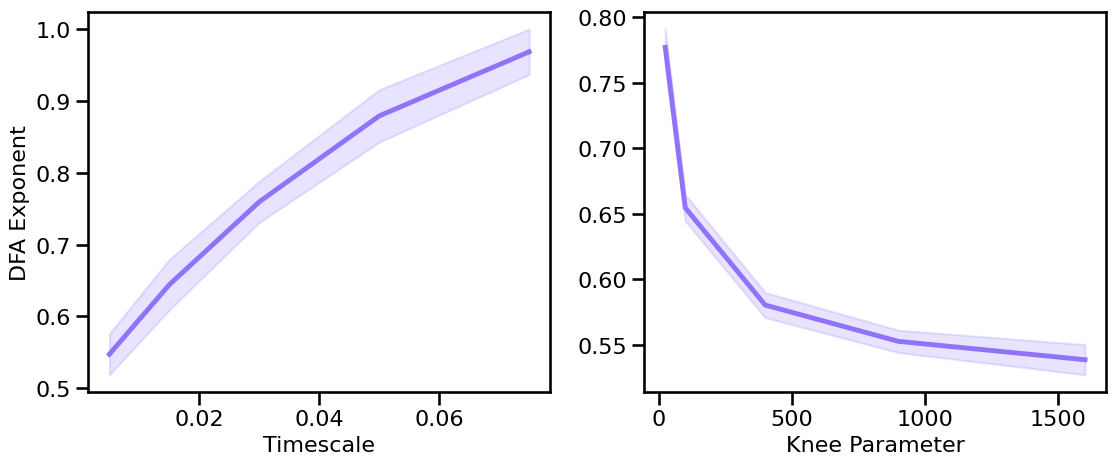

In [36]:
# Plot the estimated DFA Exponent across different timescales & knees
plot_sims_two(SIM_ITERS['syn_tscales'].values, dfa_sims_tscales, 'Timescale',
              SIM_ITERS['kn_knee'].values, dfa_sims_knee, 'Knee Parameter',
              ylabel='DFA Exponent', color=COLORS['KN'], 
              save_fig=SAVE_FIG, file_name='dfa_kn_vars' + EXT, file_path=FIGPATH)

### DFA Simulations: Periodic Variations

In [37]:
# Run simulations calculating DFA Exponent across peak bandwidth (sims from file)
dfa_sims_bw = run_sims_load(SIMPATH / 'ts_sims_comb_bw', dfa, DFA_PARAMS)

In [38]:
# Run simulations calculating DFA Exponent across burst probabilities
dfa_sims_burst = run_sims(sim_combined, SIM_ITERS['comb_burst'], dfa, DFA_PARAMS, N_SIMS)

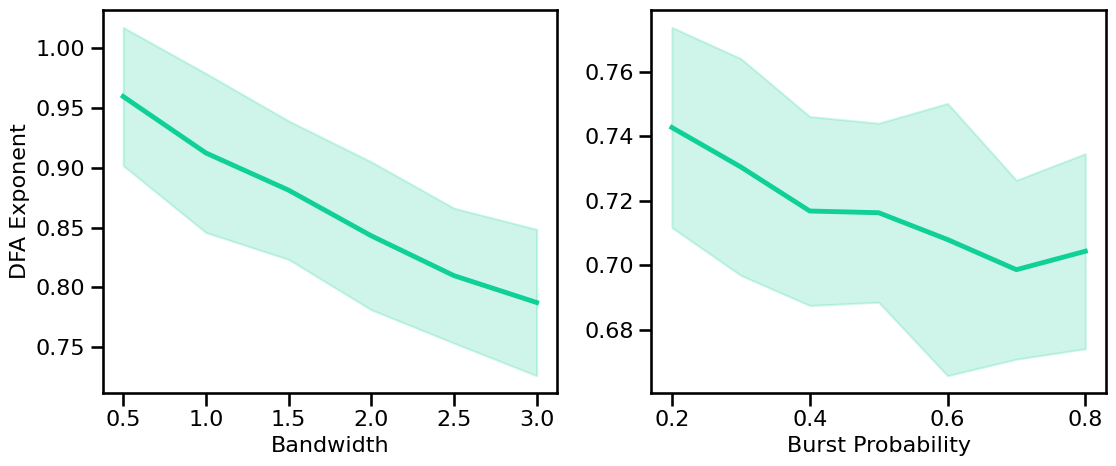

In [39]:
# Plot the estimated DFA Exponent across periodic variations
plot_sims_two(SIM_ITERS['peak_bw'].values, dfa_sims_bw, 'Bandwidth',
              SIM_ITERS['comb_burst'].values, dfa_sims_burst, 'Burst Probability',
              ylabel='DFA Exponent', color=COLORS['BW'],
              save_fig=SAVE_FIG, file_name='dfa_pe_vars' + EXT, file_path=FIGPATH)

## Conclusions

Overall, we can see the following patterns in these simulations:

Hurst Exponent:
- has a parabolic relationship with aperiodic exponent, maximal at an exponent of -1
- is less affected by oscillation, increasing slightly with increasing frequency or power

Detrended Fluctuation Analysis:
- the estimated DFA increases with increasing aperiodic exponent 
    - the expected DFA results is well estimated across a range $\chi$ from ~ 0 to 2
    - the empirical DFA becomes less close the expected for increasing exponent values
- when an oscillation is present, the expected DFA value (for the 1/f) is decreases (is under-estimated)
- there is a complex relationship between estimated DFA and oscillation frequency
- estimated DFA decreases with increasing oscillation power